In [1]:
import pandas as pd
import os

# Specify the directory containing the pickle files
directory = '../ressources/final_experiments/result_leaveoneout_exp'

# Initialize a list or dictionary to hold the DataFrames
dataframes = {}

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.pickle'):  # Check for pickle files
        file_path = os.path.join(directory, filename)  # Create full file path
        df = pd.read_pickle(file_path)  # Load the DataFrame from the pickle file
        dataframes[filename] = df  # Store the DataFrame in the dictionary

dataframes.keys()


dict_keys(['llm_evaluated_noagg.pickle', 'llm_evaluated_agg.pickle'])

In [2]:
list(dataframes.values())[0].head(3)

,index,description,configuration,parameters,argos,behavior_tree,scores,avg_score,type,lightstype,arenatype,robotstype,llm_scores,llm_behavior_tree,llm_avg_score
0,0,The environment is a circular arena with radiu...,"<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=CircularArena(radiu...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 4 --n0 0 --nchild0 2 --...,"[4.0, 2.0, 4.0, 5.0, 3.0, 4.0, 1.0, 3.0, 5.0, ...",3.600000,Foraging,TargetLights,CircularArena,CenteredSwarm,[],--nroot 3 --nchildroot 2 --n0 0 --nchild0 2 -...,None
1,1,The environment consists of a circular arena w...,"<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=CircularArena(radiu...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 1 --n0 0 --nchild0 2 --...,"[3.0, 3.0, 4.0, 2.0, 1.0, 2.0, 5.0, 3.0, 4.0, ...",2.900000,Foraging,UniformLights,CircularArena,CenteredSwarm,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, ...",--nroot 3 --nchildroot 2 --n0 0 --nchild0 2 -...,0.8
2,2,"With a radius of 3.44 meters, the circular are...","<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=CircularArena(radiu...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 3 --n0 0 --nchild0 2 --...,"[-8.57746, -4.79552, -7.16427, -9.41532, -6.30...",-7.018138,Connection,UniformLights,CircularArena,CenteredSwarm,"[-6.2355, -10.3745, -9.90394, -8.86366, -5.961...",--nroot 3 --nchildroot 2 --n0 0 --nchild0 2 -...,-8.225772


In [3]:
df_agg = dataframes["llm_evaluated_agg.pickle"]
df_control = pd.read_pickle('../ressources/final_experiments/result_increasing_size_exp/llm_evaluated_1575.pickle')
df_control = df_control[df_control["type"] == "Aggregation"] 

In [4]:

# Combine the two scores into a single DataFrame
# Use the minimum length to avoid ValueError
min_length = min(len(df_agg), len(df_control))

combined_df = pd.DataFrame({
    'llm_avg_score_transfer': df_agg['llm_avg_score'].values[:min_length],
    'llm_avg_score_train': df_control['llm_avg_score'].values[:min_length],
    'type': df_control['type'].values[:min_length]  # Assuming you want the type from df_white
})

combined_df.head(3)

,llm_avg_score_transfer,llm_avg_score_train,type
0,0.000,0.000000,Aggregation
1,0.125,0.116667,Aggregation
2,0.000,0.000000,Aggregation


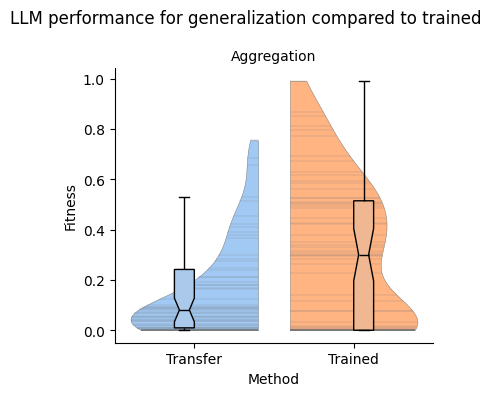

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def generate_violin_boxplot(df, id_var='type', value_vars=['avg_score', 'llm_avg_score'], 
                             score_labels={'avg_score': 'AutoMoDe', 'llm_avg_score': 'LLM'}, 
                             title='Performance Distributions by Mission and Method'):
    """
    Generate a violin and box plot for the given DataFrame.

    Parameters:
    - df: DataFrame containing the data to plot.
    - id_var: Column name to use as identifier variable (default is 'type').
    - value_vars: List of column names to melt (default is ['avg_score', 'llm_avg_score']).
    - score_labels: Dictionary to map score variable names to display labels.
    - title: Title of the plot.
    """
    # Melt the DataFrame
    df_melted = df.melt(id_vars=[id_var], value_vars=value_vars, 
                         var_name='Score Type', value_name='Score')

    # Create a FacetGrid with violin plots
    g = sns.FacetGrid(df_melted, col=id_var, height=4, aspect=1, sharex=True, sharey=False)
    g.map_dataframe(sns.violinplot, x='Score Type', y='Score', hue='Score Type', 
                    split=True, inner='stick', density_norm='area', 
                    palette="pastel", cut=0, dodge=False, native_scale=True, 
                    legend="auto", saturation=1.0, linewidth=0.33)

    # Overlay notched boxplots
    g.map_dataframe(sns.boxplot, x='Score Type', y='Score', hue='Score Type', 
                    dodge=True, width=0.25, palette="pastel", 
                    fliersize=0, notch=True, linewidth=1.0, linecolor="black")

    # Set titles and labels
    g.set_titles(col_template='{col_name}')
    g.set_axis_labels('Method', 'Fitness')

    # Rename the x-tick labels
    for ax in g.axes.flat:
        # Get the current tick positions
        ticks = ax.get_xticks()
        # Set the new tick labels
        ax.set_xticks(ticks)
        ax.set_xticklabels([score_labels.get(label, label) for label in value_vars])

    # Add a title to the figure
    g.figure.suptitle(title)
    g.tight_layout()
    plt.show()


generate_violin_boxplot(combined_df, id_var='type', value_vars=['llm_avg_score_transfer',"llm_avg_score_train"], 
                             score_labels={'llm_avg_score_transfer': 'Transfer', 'llm_avg_score_train': 'Trained'}, 
                             title='LLM performance for generalization compared to trained ')

/tmp/ipykernel_18725/1780316537.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='source', y='llm_avg_score', data=combined_df,
/tmp/ipykernel_18725/1780316537.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(x='source', y='llm_avg_score', data=combined_df,
/tmp/ipykernel_18725/1780316537.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='source', y='llm_avg_score', data=combined_df,
/tmp/ipykernel_18725/1780316537.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(x='source', y='llm_avg_score', data=combined_df,


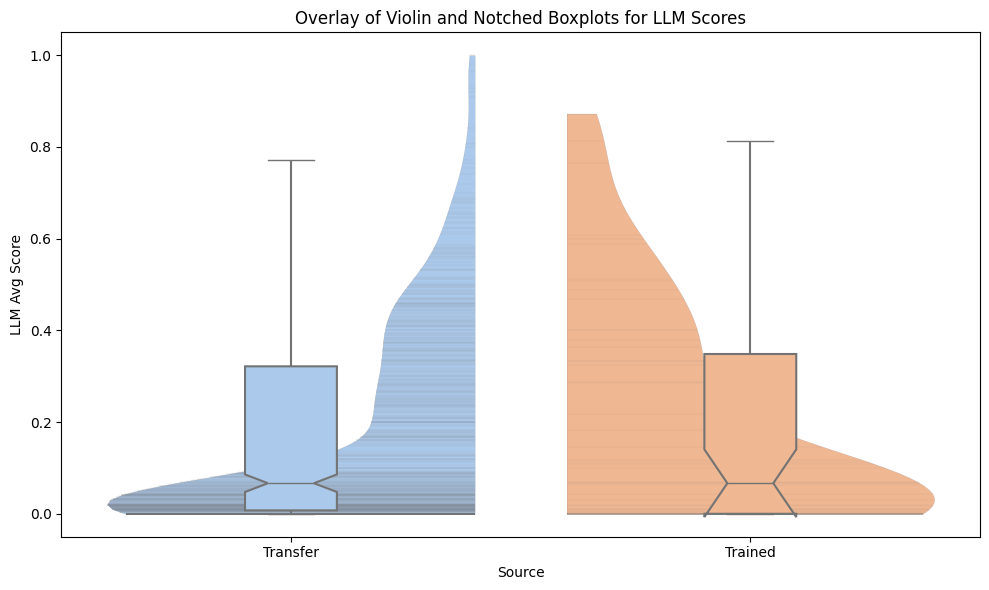

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the control DataFrame
df_control = pd.read_pickle('../ressources/final_experiments/result_increasing_size_exp/llm_evaluated_675.pickle')
df_control = df_control[df_control["type"] == "Aggregation"]

# Assuming df_agg is already defined and contains the other DataFrame

# Create a combined DataFrame for plotting
df_agg['source'] = 'Transfer'
df_control['source'] = 'Trained'

# Combine the two DataFrames
combined_df = pd.concat([df_agg[['llm_avg_score', 'source']], df_control[['llm_avg_score', 'source']]], ignore_index=True)

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the violin plot with pastel colors and inner sticks
palette = sns.color_palette("pastel")
sns.violinplot(x='source', y='llm_avg_score', data=combined_df, 
               inner='stick', palette=palette, density_norm='width', cut=0, linewidth=0.1, split=True)

# Overlay the notched boxplot with the same colors
sns.boxplot(x='source', y='llm_avg_score', data=combined_df, 
            notch=True, width=0.2, palette=palette, 
            boxprops=dict(linewidth=1.5), whiskerprops=dict(linewidth=1.5), 
            fliersize=0)  # Set fliersize to 0 to hide outliers

# Set titles and labels
plt.title('Overlay of Violin and Notched Boxplots for LLM Scores')
plt.xlabel('Source')
plt.ylabel('LLM Avg Score')

# Show the plot
plt.tight_layout()
plt.show()


In [24]:
combined_df = combined_df[combined_df.type == "Aggregation"]

In [33]:
df_agg.keys()

Index(['index', 'description', 'configuration', 'parameters', 'argos',
       'behavior_tree', 'scores', 'avg_score', 'type', 'lightstype',
       'arenatype', 'robotstype', 'llm_scores', 'llm_behavior_tree',
       'llm_avg_score'],
      dtype='object')

In [36]:
df_agg.llm_avg_score.max(), df_agg.llm_avg_score.min(), df_agg.llm_avg_score.mean(), df_agg.llm_avg_score.median()

(np.float64(1.0),
 np.float64(0.0),
 np.float64(0.17969309263868066),
 np.float64(0.0666667))

In [25]:

def compute_statistics(data_transfer, data_train):
    """
    Computes the minimum, maximum, mean, and median statistics for transfer and training scores.

    Parameters:
    - data_transfer: A numpy array or list of transfer scores.
    - data_train: A numpy array or list of training scores.

    Returns:
    - A pandas DataFrame containing the statistics.
    """
    stats_summary = {
        'Statistic': ['Min', 'Max', 'Mean', 'Median'],
        'Transfer Scores': [data_transfer.min(), data_transfer.max(), data_transfer.mean(), pd.Series(data_transfer).median()],
        'Training Scores': [data_train.min(), data_train.max(), data_train.mean(), pd.Series(data_train).median()]
    }

    # Create a DataFrame for the summary statistics
    stats_df = pd.DataFrame(stats_summary)
    return stats_df

compute_statistics(combined_df.llm_avg_score_transfer, combined_df.llm_avg_score_train)

,Statistic,Transfer Scores,Training Scores
0,Min,0.000000,0.000000
1,Max,1.000000,0.872727
2,Mean,0.184327,0.195050
3,Median,0.068375,0.066667


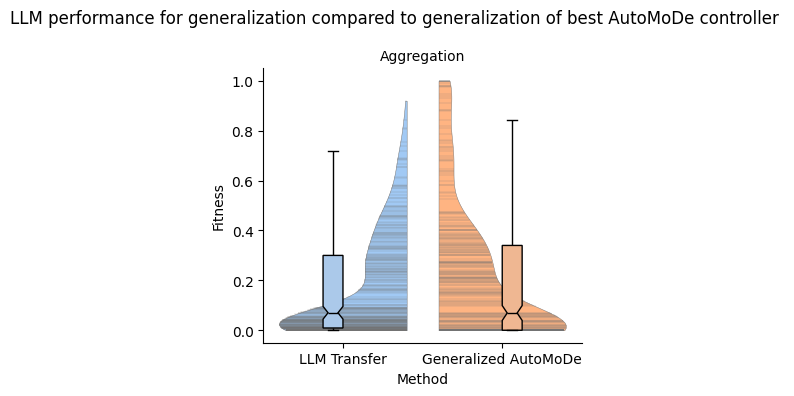

In [13]:
df_control = pd.read_pickle('../ressources/automode_bt_evaluated_agg_black_only.pickle')
#df_control = df_control[df_control["type"] == "Aggregation"] 

# Combine the two scores into a single DataFrame
# Use the minimum length to avoid ValueError
min_length = min(len(df_agg), len(df_control))

combined_df = pd.DataFrame({
    'llm_avg_score_transfer': df_agg['llm_avg_score'].values[:min_length],
    'llm_avg_score_train': df_control['bt_avg_score'].values[:min_length],
    'type': df_control['type'].values[:min_length]  # Assuming you want the type from df_white
})

combined_df.head(3)

generate_violin_boxplot(combined_df, id_var='type', value_vars=['llm_avg_score_transfer',"llm_avg_score_train"], 
                             score_labels={'llm_avg_score_transfer': 'LLM Transfer', 'llm_avg_score_train': 'Generalized AutoMoDe'}, 
                             title='LLM performance for generalization compared to generalization of best AutoMoDe controller ')

In [9]:
combined_df.head()

,llm_avg_score_transfer,llm_avg_score_train,type
0,0.000000,0.000000,Aggregation
1,0.125000,0.000000,Aggregation
2,0.000000,0.000000,Aggregation
3,0.087500,0.000000,Aggregation
4,0.077778,0.233333,Aggregation


[{'Dataset': 'Aggregation', 'Wilcoxon Statistic': np.float64(19751.0), 'P-Value': np.float64(0.3461619060744502)}]


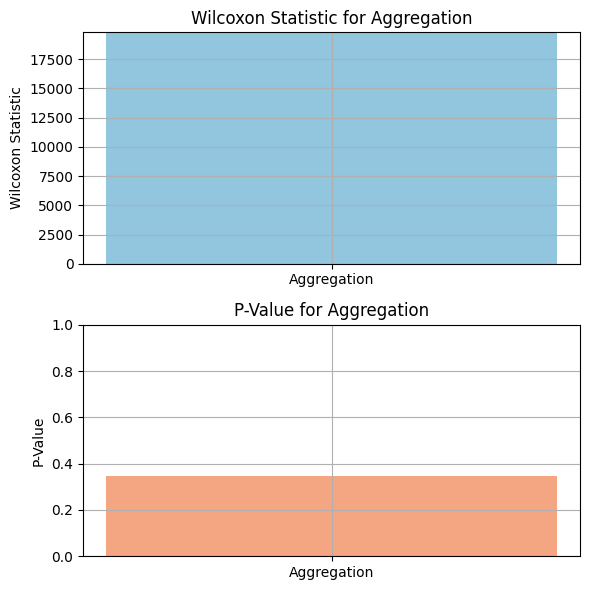

In [10]:
from scipy.stats import wilcoxon
# Extract the data for the Wilcoxon test
data_transfer = combined_df['llm_avg_score_transfer'].to_numpy()
data_train = combined_df['llm_avg_score_train'].to_numpy()

# Compute the two-sided Wilcoxon signed-rank test
stat, p_value = wilcoxon(data_transfer, data_train)

# Store results in a dictionary (or a list if you have multiple groups)
stats_list = [{
    'Dataset': 'Aggregation',  # You can change this based on your actual dataset
    'Wilcoxon Statistic': stat,
    'P-Value': p_value
}]

# Print the results
print(stats_list)

# Plot the Wilcoxon test result
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Plot Wilcoxon Statistic
ax[0].bar(stats_list[0]['Dataset'], stat, color='#92c5de')
ax[0].set_title(f"Wilcoxon Statistic for {stats_list[0]['Dataset']}")
ax[0].set_ylabel('Wilcoxon Statistic')
ax[0].set_ylim(0, max(stat, 1) + 50)  # Adjust y-axis to fit the statistic
ax[0].grid(True)

# Plot P-Value
ax[1].bar(stats_list[0]['Dataset'], p_value, color='#f4a582')
ax[1].set_title(f"P-Value for {stats_list[0]['Dataset']}")
ax[1].set_ylabel('P-Value')
ax[1].set_ylim(0, 1)  # P-value is between 0 and 1
ax[1].grid(True)

plt.tight_layout()
plt.show()

  Statistic  Transfer Scores  Training Scores
0       Min         0.000000         0.000000
1       Max         0.920000         1.000000
2      Mean         0.176418         0.213189
3    Median         0.070089         0.069091
[{'Dataset': 'Aggregation', 'Wilcoxon Statistic': np.float64(19751.0), 'P-Value': np.float64(0.826919046962775), 'Mean Transfer': np.float64(0.17641810471875), 'Mean Train': np.float64(0.21318877287500002)}]
The data transfer scores are not significantly greater than the training scores.


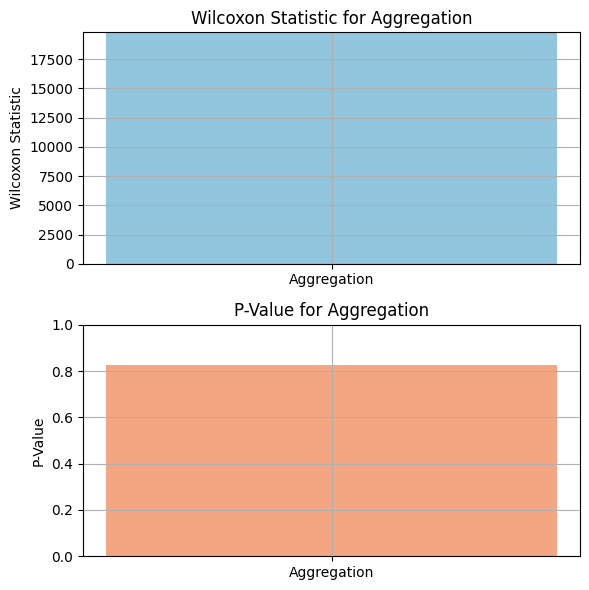

In [11]:
# Extract the data for the Wilcoxon test
data_transfer = combined_df['llm_avg_score_transfer'].to_numpy()
data_train = combined_df['llm_avg_score_train'].to_numpy()

# Compute the one-sided Wilcoxon signed-rank test (testing if transfer scores are greater)
stat, p_value = wilcoxon(data_transfer, data_train, alternative='greater')

# Calculate statistics
stats_summary = {
    'Statistic': ['Min', 'Max', 'Mean', 'Median'],
    'Transfer Scores': [data_transfer.min(), data_transfer.max(), data_transfer.mean(), pd.Series(data_transfer).median()],
    'Training Scores': [data_train.min(), data_train.max(), data_train.mean(), pd.Series(data_train).median()]
}

# Create a DataFrame for the summary statistics
stats_df = pd.DataFrame(stats_summary)

# Print the summary statistics table
print(stats_df)

# Calculate means
mean_transfer = data_transfer.mean()
mean_train = data_train.mean()

# Store results in a dictionary (or a list if you have multiple groups)
stats_list = [{
    'Dataset': 'Aggregation',  # You can change this based on your actual dataset
    'Wilcoxon Statistic': stat,
    'P-Value': p_value,
    'Mean Transfer': mean_transfer,
    'Mean Train': mean_train
}]

# Print the results
print(stats_list)

# Check if the mean of transfer is significantly greater than the mean of train
if p_value < 0.05 and mean_transfer > mean_train:
    print("The data transfer scores are significantly greater than the training scores.")
else:
    print("The data transfer scores are not significantly greater than the training scores.")

# Plot the Wilcoxon test result
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Plot Wilcoxon Statistic
ax[0].bar(stats_list[0]['Dataset'], stat, color='#92c5de')
ax[0].set_title(f"Wilcoxon Statistic for {stats_list[0]['Dataset']}")
ax[0].set_ylabel('Wilcoxon Statistic')
ax[0].set_ylim(0, max(stat, 1) + 50)  # Adjust y-axis to fit the statistic
ax[0].grid(True)

# Plot P-Value
ax[1].bar(stats_list[0]['Dataset'], p_value, color='#f4a582')
ax[1].set_title(f"P-Value for {stats_list[0]['Dataset']}")
ax[1].set_ylabel('P-Value')
ax[1].set_ylim(0, 1)  # P-value is between 0 and 1
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [12]:

def compute_statistics(data_transfer, data_train):
    """
    Computes the minimum, maximum, mean, and median statistics for transfer and training scores.

    Parameters:
    - data_transfer: A numpy array or list of transfer scores.
    - data_train: A numpy array or list of training scores.

    Returns:
    - A pandas DataFrame containing the statistics.
    """
    stats_summary = {
        'Statistic': ['Min', 'Max', 'Mean', 'Median'],
        'Transfer Scores': [data_transfer.min(), data_transfer.max(), data_transfer.mean(), pd.Series(data_transfer).median()],
        'Training Scores': [data_train.min(), data_train.max(), data_train.mean(), pd.Series(data_train).median()]
    }

    # Create a DataFrame for the summary statistics
    stats_df = pd.DataFrame(stats_summary)
    return stats_df

compute_statistics(data_transfer, data_train)

,Statistic,Transfer Scores,Training Scores
0,Min,0.000000,0.000000
1,Max,0.920000,1.000000
2,Mean,0.176418,0.213189
3,Median,0.070089,0.069091
